In [106]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

In [107]:
df = pd.read_csv('../input/merged_data_ALL3.csv')

In [108]:
features = ['001_SS_Close', '399_SZ_Close', 'HIS_Close', 'IXIC_Close', 'FTSE_Close', 'JM0_Close']
target = '600_Close'

In [109]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [110]:
# 创建视窗数据集
def create_sequences(data, target, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        label = target[i + window_size]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [111]:
window_size = 300
X, y = create_sequences(df[features].values, df[target].values, window_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [112]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [113]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [114]:
import torch.nn as nn
import torch.optim as optim

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 定义模型、损失函数和优化器
input_size = len(features)
hidden_size = 50
output_size = 1
model_rnn = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)

# 训练RNN模型
num_epochs = 60
model_rnn.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_rnn(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 评估RNN模型
model_rnn.eval()
with torch.no_grad():
    y_pred_rnn = model_rnn(X_test_tensor)
    rnn_mse = criterion(y_pred_rnn, y_test_tensor).item()
    print("RNN的均方误差:", rnn_mse)


Epoch [10/60], Loss: 33.3620
Epoch [20/60], Loss: 13.0451
Epoch [30/60], Loss: 7.0824
Epoch [40/60], Loss: 3.7319
Epoch [50/60], Loss: 1.3604
Epoch [60/60], Loss: 0.5886
RNN的均方误差: 0.46685147285461426


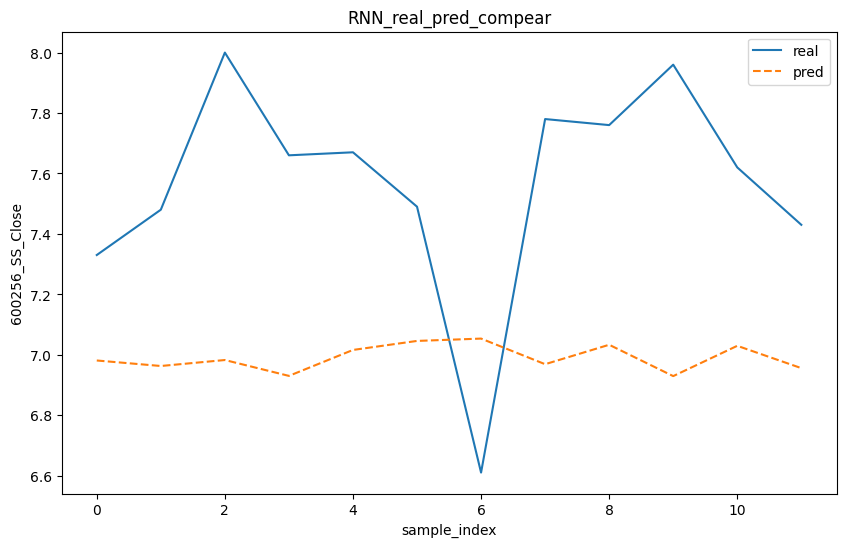

In [115]:
import matplotlib.pyplot as plt
# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(y_test_tensor.numpy(), label='real')
plt.plot(y_pred_rnn.numpy(), label='pred', linestyle='--')
plt.legend()
plt.title('RNN_real_pred_compear')
plt.xlabel('sample_index')
plt.ylabel('600256_SS_Close')
plt.show()

In [116]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 定义模型、损失函数和优化器
model_lstm = LSTMModel(input_size, hidden_size, output_size)
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

# 训练LSTM模型
model_lstm.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_lstm(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 评估LSTM模型
model_lstm.eval()
with torch.no_grad():
    y_pred_lstm = model_lstm(X_test_tensor)
    lstm_mse = criterion(y_pred_lstm, y_test_tensor).item()
    print("LSTM的均方误差:", lstm_mse)


Epoch [10/60], Loss: 49.5745
Epoch [20/60], Loss: 21.1277
Epoch [30/60], Loss: 6.6197
Epoch [40/60], Loss: 1.8013
Epoch [50/60], Loss: 0.6188
Epoch [60/60], Loss: 0.2318
LSTM的均方误差: 0.1468423455953598


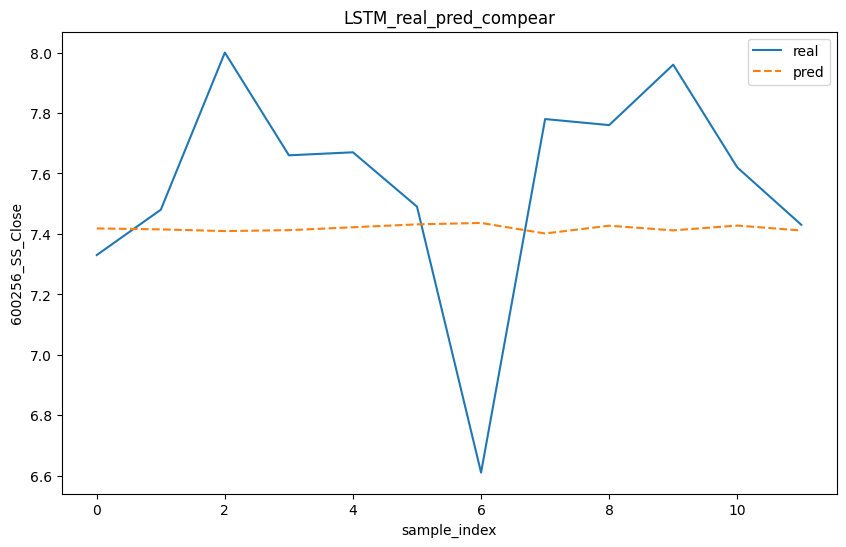

In [117]:
import matplotlib.pyplot as plt

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(y_test_tensor.numpy(), label='real')
plt.plot(y_pred_lstm.numpy(), label='pred', linestyle='--')
plt.legend()
plt.title('LSTM_real_pred_compear')
plt.xlabel('sample_index')
plt.ylabel('600256_SS_Close')
plt.show()
